In [3]:
pip install fairlearn matplotlib scikit-learn joblib pandas numpy

     -------------------------------------- 240.0/240.0 kB 7.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import os, json
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
from fairlearn.metrics import (
    MetricFrame, selection_rate,
    demographic_parity_difference, demographic_parity_ratio,
    equalized_odds_difference
)

plt.rcParams["figure.figsize"] = (7,4)

REPORTS_DIR = "../reports"
MODELS_DIR = "../models"
DATA_PATH = "../data/processed/loan_approval_clean.csv"

os.makedirs(REPORTS_DIR, exist_ok=True)

In [6]:
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

df["loan_status"] = df["loan_status"].astype(str).str.strip().str.lower()
label_map = {"approved": 1, "rejected": 0}
df = df[df["loan_status"].isin(label_map)].copy()

y = df["loan_status"].map(label_map).astype(int)
X = df.drop(columns=["loan_status", "loan_id"], errors="ignore")

print("Data:", X.shape, "Target balance:", y.value_counts(normalize=True).round(3).to_dict())

Data: (4269, 11) Target balance: {1: 0.622, 0: 0.378}


In [7]:
metrics_path = os.path.join(REPORTS_DIR, "metrics.json")
if os.path.exists(metrics_path):
    with open(metrics_path) as f:
        all_metrics = json.load(f)
    def score_key(m):
        return (m.get("roc_auc", 0.0), m.get("f1", 0.0))
    best_name = max(all_metrics, key=lambda k: score_key(all_metrics[k]))
else:
    best_name = "random_forest"

model_path = os.path.join(MODELS_DIR, f"{best_name}.pkl")
print("Loading model:", model_path)
model = joblib.load(model_path)

y_pred = pd.Series(model.predict(X), index=y.index).astype(int)
print("Pred label distribution:", y_pred.value_counts(normalize=True).round(3).to_dict())

Loading model: ../models\random_forest.pkl
Pred label distribution: {1: 0.623, 0: 0.377}


In [8]:
def fairness_eval(y_true, y_pred, sensitive_series, unknown_label="Unknown"):
    y_true = pd.Series(y_true).reset_index(drop=True).astype(int)
    y_pred = pd.Series(y_pred).reset_index(drop=True).astype(int)
    sens = pd.Series(sensitive_series).reset_index(drop=True)
    sens = sens.astype("object").fillna(unknown_label)
    sens = sens.astype(str).str.strip().replace(r"^$", unknown_label, regex=True)

    mask = y_true.notna() & y_pred.notna() & sens.notna()
    y_t, y_p, s = y_true[mask].to_numpy(), y_pred[mask].to_numpy(), sens[mask].to_numpy()

    metrics = {
        "accuracy": accuracy_score,
        "precision": precision_score,
        "recall": recall_score,
        "f1": f1_score,
        "selection_rate": selection_rate,
    }
    mf = MetricFrame(metrics=metrics, y_true=y_t, y_pred=y_p, sensitive_features=s)

    dp_diff  = demographic_parity_difference(y_t, y_p, sensitive_features=s)
    dp_ratio = demographic_parity_ratio(y_t, y_p, sensitive_features=s)
    eo_diff  = equalized_odds_difference(y_t, y_p, sensitive_features=s)

    out = {
        "overall": {k: float(v) for k, v in mf.overall.items()},
        "by_group": {m: pd.Series(mf.by_group[m]).to_dict() for m in mf.by_group.columns},
        "disparities": {
            "demographic_parity_difference": float(dp_diff),
            "demographic_parity_ratio": float(dp_ratio),
            "equalized_odds_difference": float(eo_diff),
        },
    }
    return out, mf, s


=== EDUCATION ===
Overall: {'accuracy': 0.996252049660342, 'precision': 0.9966139954853274, 'recall': 0.9973644578313253, 'f1': 0.9969890854347008, 'selection_rate': 0.6226282501756851}
Disparities: {'demographic_parity_difference': 0.00195368744512725, 'demographic_parity_ratio': 0.9968670861014564, 'equalized_odds_difference': 0.003699034499723264}


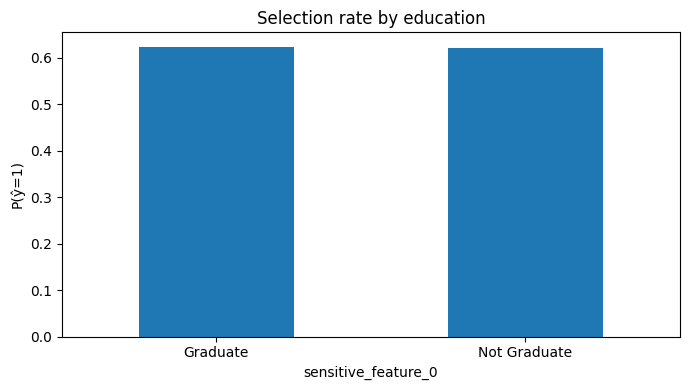

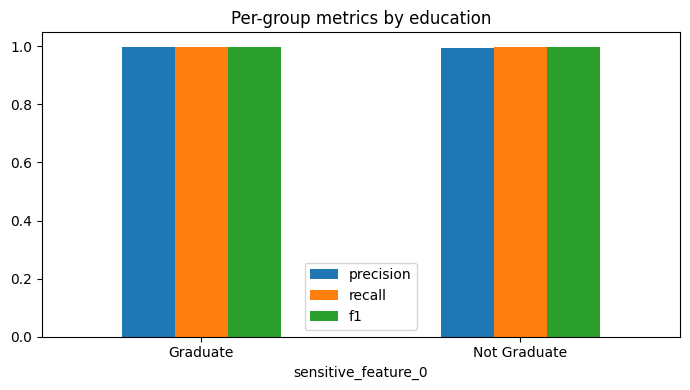


=== SELF_EMPLOYED ===
Overall: {'accuracy': 0.996252049660342, 'precision': 0.9966139954853274, 'recall': 0.9973644578313253, 'f1': 0.9969890854347008, 'selection_rate': 0.6226282501756851}
Disparities: {'demographic_parity_difference': 0.0012643085264001375, 'demographic_parity_ratio': 0.9979714452748057, 'equalized_odds_difference': 0.002298858396220238}


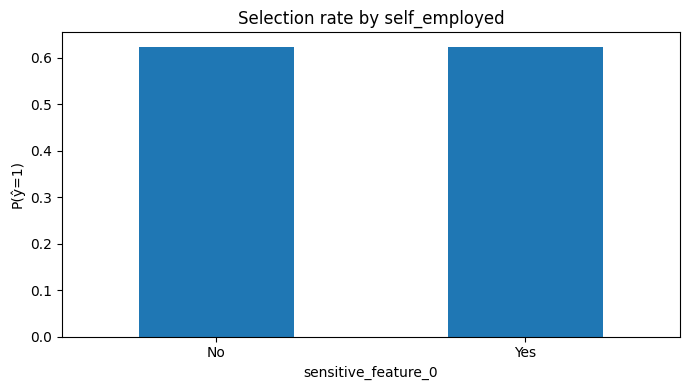

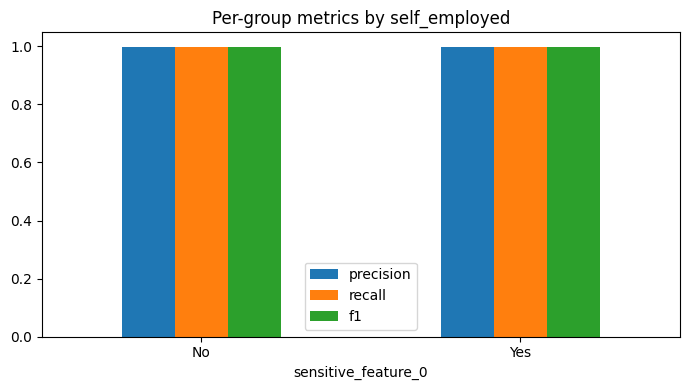

In [9]:
sensitive_cols = [c for c in ["education", "self_employed"] if c in df.columns]
assert len(sensitive_cols) > 0, "No valid sensitive columns found."

results = {}

for col in sensitive_cols:
    res, mf, sens = fairness_eval(y, y_pred, df[col])
    results[col] = res

    print(f"\n=== {col.upper()} ===")
    print("Overall:", res["overall"])
    print("Disparities:", res["disparities"])

    pd.Series(mf.by_group["selection_rate"]).plot(kind="bar", rot=0)
    plt.title(f"Selection rate by {col}")
    plt.ylabel("P(ŷ=1)"); plt.tight_layout(); plt.show()

    mf.by_group[["precision","recall","f1"]].plot(kind="bar", rot=0)
    plt.title(f"Per-group metrics by {col}")
    plt.tight_layout(); plt.show()

In [10]:
def confusions_by_group(y_true, y_pred, s):
    out = {}
    s = pd.Series(s)
    for g in s.unique():
        mask = s == g
        tn, fp, fn, tp = confusion_matrix(y_true[mask], y_pred[mask]).ravel()
        out[str(g)] = {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)}
    return out

for col in sensitive_cols:
    _, mf, sens = fairness_eval(y, y_pred, df[col])
    print(f"\nConfusion by {col}:")
    print(confusions_by_group(pd.Series(y), pd.Series(y_pred), pd.Series(sens)))


Confusion by education:
{'Graduate': {'tn': 802, 'fp': 3, 'fn': 5, 'tp': 1334}, 'Not Graduate': {'tn': 802, 'fp': 6, 'fn': 2, 'tp': 1315}}

Confusion by self_employed:
{'No': {'tn': 796, 'fp': 5, 'fn': 5, 'tp': 1313}, 'Yes': {'tn': 808, 'fp': 4, 'fn': 2, 'tp': 1336}}


In [11]:
report = {"model": best_name, "fairness": results}
out_path = os.path.join(REPORTS_DIR, "fairness.json")
with open(out_path, "w") as f:
    json.dump(report, f, indent=2)
print("Saved:", out_path)

Saved: ../reports\fairness.json


,threshold,accuracy,dp_diff,selection_rate_overall
0,0.20,0.986179,0.007925,0.635980
1,0.25,0.990630,0.007496,0.631530
2,0.30,0.992036,0.007509,0.630124
3,0.35,0.995081,0.006131,0.627079
4,0.40,0.996252,0.005677,0.625439


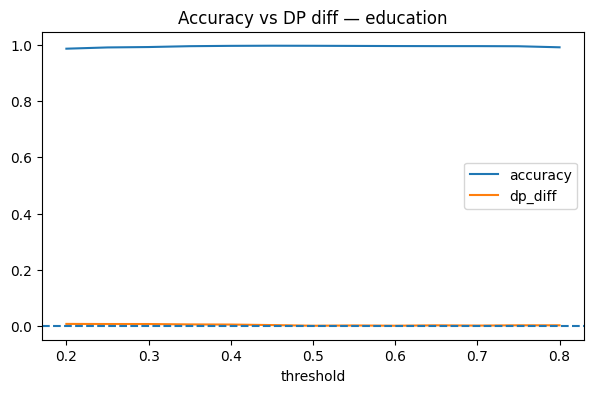

,threshold,accuracy,dp_diff,selection_rate_overall
0,0.20,0.986179,0.000335,0.635980
1,0.25,0.990630,0.001135,0.631530
2,0.30,0.992036,0.000719,0.630124
3,0.35,0.995081,0.000206,0.627079
4,0.40,0.996252,0.001588,0.625439


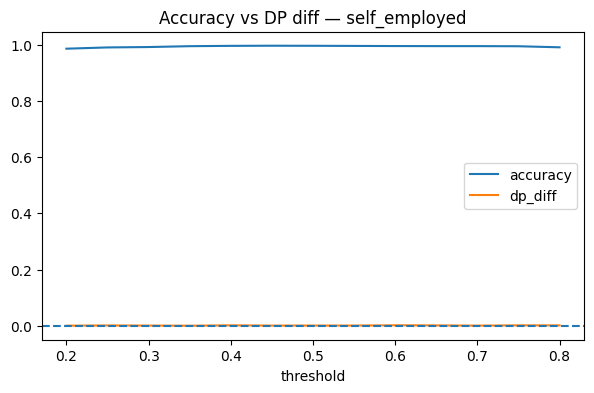

In [12]:
if hasattr(model, "predict_proba"):
    probs = model.predict_proba(X)[:,1]

    def scan_thresholds(sens_col, thresholds=np.linspace(0.2, 0.8, 13)):
        rows = []
        s = df[sens_col].astype(str).str.strip().replace(r"^$", "Unknown", regex=True)
        for t in thresholds:
            y_hat = (probs >= t).astype(int)
            rows.append({
                "threshold": float(t),
                "accuracy": float(accuracy_score(y, y_hat)),
                "dp_diff": float(demographic_parity_difference(y, y_hat, sensitive_features=s)),
                "selection_rate_overall": float(selection_rate(y, y_hat))
            })
        return pd.DataFrame(rows)

    for col in sensitive_cols:
        scan = scan_thresholds(col)
        display(scan.head())
        ax = scan.plot(x="threshold", y=["accuracy", "dp_diff"])
        ax.axhline(0, linestyle="--"); plt.title(f"Accuracy vs DP diff — {col}")
        plt.show()